# Modelación de sistema lineal con condiciones iniciales mediante red neuronal físicamente informada

La red neuronal tiene como entrada un tiempo y como salida el desplazamiento del sistema para ese tiempo. La función de costo incorpora el residual de la ecuación diferencial del movimiento y el residual de las condiciones iniciales verdaderas versus predichas. Se utiliza un perceptrón multicapa como red neuronal. Tomando unos instantes de tiempo aleatorios dentro de un rango, el modelo hace las predicciones de los desplazamientos y se calculan los gradientes para optimizar los pesos hasta minimizar la función de costo.

## Importa módulos

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt


2024-10-24 14:26:32.018559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 14:26:32.240541: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 14:26:33.016868: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/feleaman/miniconda3/envs/tf/lib/
2024-10-24 14:26:33.018003: W tensorflow/compiler/xla/stre

## Solución teórica

Sistema subamortiguado


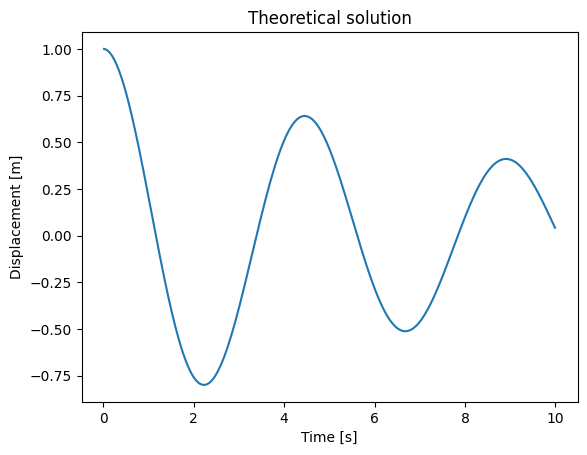

In [21]:
n_points = 1000
tr = 10 #tiempo de registro
t = tr*np.random.rand(n_points, 1)  #puntos de tiempo aleatorios
t = np.sort(t, axis=0)

m = 1. # masa
k = 2. # rigidez
c = 0.2 # amortiguamiento

# m = 10 #masa
# k = 1000 #rigidez
# c = 300 #amortiguamiento

x0 = 1 #v.i. desplazamiento
xp0 = 0 # v.i. velocidad

wn = np.sqrt(k/m)
chi = c / (2*m*wn)

if chi > 1: #sobreamortiguado
    print('Sistema sobreamortiguado')
    p1 = -chi*wn + wn*np.sqrt(chi**2-1)
    p2 = -chi*wn - wn*np.sqrt(chi**2-1)
    a1 = (x0*p2 - xp0)/(p2-p1)
    a2 = (xp0 - p1*x0)/(p2-p1)
    x = a1*np.exp(p1*t) + a2*np.exp(p2*t)
elif chi < 1: #subamortiguado
    print('Sistema subamortiguado')
    wd = wn*np.sqrt(1-chi**2)
    alpha = -chi*wn
    beta = wd
    X = np.sqrt(x0**2 + ((xp0**2 - alpha*x0)/beta)**2 )
    phi = np.arctan2(beta*x0, xp0 - alpha*x0)
    x = X*np.exp(alpha*t)*np.sin(beta*t + phi)

plt.plot(t, x, label='teorico')
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.title('Theoretical solution')
plt.show()


## Solución mediante red neuronal

### Define modelo y función de costo

In [14]:
class PINN(Model):
    def __init__(self, layers_dims):
        super(PINN, self).__init__()
        self.hidden_layers = [layers.Dense(units, activation='tanh') for units in layers_dims]
        self.output_layer = layers.Dense(1, activation=None) 

    def call(self, z):
        for layer in self.hidden_layers:
            z = layer(z)
        return self.output_layer(z)

def physics_loss(model, t, m, c, k):
    with tf.GradientTape(persistent=False) as tape2:
        tape2.watch(t)
        with tf.GradientTape(persistent=False) as tape1:
            tape1.watch(t)
            x = model(t)  # entra tiempo al modelo y sale desplazamiento
        x_t = tape1.gradient(x, t)  # primera derivada - velocidad
    x_tt = tape2.gradient(x_t, t)  # segunda derivada - aceleración
    loss = tf.reduce_mean( tf.square((m*x_tt + c*x_t + k*x) ) )  # residual de la ecuación del movimiento al cuadrado
    return loss

def initial_loss(model, x0, xp0):
    t0 = tf.constant([[0.0]])
    x0_predict = model(t0)  # predicción de desplazamiento para t=0
        
    with tf.GradientTape() as tape:
        tape.watch( t0 )
        x0_predict = model(t0)                   
    xp0_predict = tape.gradient(x0_predict, t0)  # predicción de velocidad para t=0
    loss = tf.reduce_mean( tf.square(x0-x0_predict) ) + tf.reduce_mean( tf.square(xp0-xp0_predict) )  # residual de ambas condiciones iniciales al cuadrado
    return loss

def total_loss(model, x, m, c, k, x0, xp0):
    return physics_loss(model, x, m, c, k) + initial_loss(model, x0, xp0) # costo total



### Entrena el modelo

In [19]:
t_train = tr*np.random.rand(n_points, 1)  #puntos de tiempo aleatorios
t_train = tf.convert_to_tensor(t_train, dtype=tf.float32)

layers_dims = [20, 20, 20]  # neuronas y capas ocultas
pinn = PINN(layers_dims) #inicializa modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) #define optimizador

epochs = 5000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss_value = total_loss(pinn, t_train, m, c, k, x0, xp0)
    gradients = tape.gradient(loss_value, pinn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss_value.numpy()}')


Epoch 0, Loss: 3.2275712490081787
Epoch 50, Loss: 0.29489630460739136
Epoch 100, Loss: 0.2186032235622406
Epoch 150, Loss: 0.1681845784187317
Epoch 200, Loss: 0.1345999538898468
Epoch 250, Loss: 0.12279218435287476
Epoch 300, Loss: 0.11974984407424927
Epoch 350, Loss: 0.11767221242189407
Epoch 400, Loss: 0.11546418815851212
Epoch 450, Loss: 0.1132802814245224
Epoch 500, Loss: 0.11111585795879364
Epoch 550, Loss: 0.10888545960187912
Epoch 600, Loss: 0.1066427156329155
Epoch 650, Loss: 0.1042226105928421
Epoch 700, Loss: 0.1016315445303917
Epoch 750, Loss: 0.09887092560529709
Epoch 800, Loss: 0.09589006006717682
Epoch 850, Loss: 0.09270200878381729
Epoch 900, Loss: 0.08951690047979355
Epoch 950, Loss: 0.08625680208206177
Epoch 1000, Loss: 0.08320321887731552
Epoch 1050, Loss: 0.08036825805902481
Epoch 1100, Loss: 0.07774986326694489
Epoch 1150, Loss: 0.07527607679367065
Epoch 1200, Loss: 0.07284654676914215
Epoch 1250, Loss: 0.07025023549795151
Epoch 1300, Loss: 0.06752247363328934
Epoch

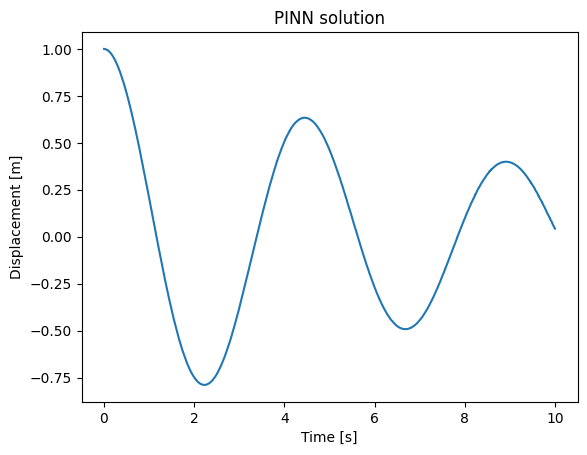

In [20]:
t_test = tr*np.random.rand(n_points, 1)  #puntos de tiempo aleatorios
t_test = np.sort(t_test, axis=0) #los ordena
t_test = tf.convert_to_tensor(t_test, dtype=tf.float32)

x_pred = pinn(t_test).numpy() #predice desplazamientos para los instantes de tiemo

plt.plot(t_test, x_pred, label='PINN prediction')
plt.title('PINN solution')
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.show()

## Comparación entre soluciones

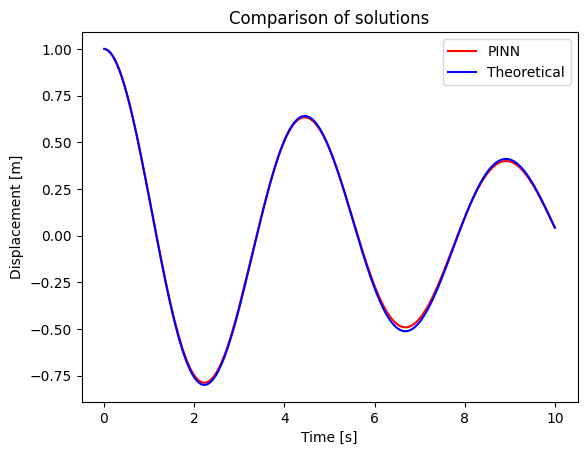

In [23]:
plt.plot(t_test, x_pred, label='PINN', color='red')
plt.plot(t, x, label='Theoretical', color='blue')
plt.title('Comparison of solutions')
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.legend()
plt.show()